<a href="https://colab.research.google.com/github/aljeshishe/notebooks/blob/master/template_vgg_gpu_v2_with_wb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt 
import sys 

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from time import time 

In [0]:
import os
# use gpu/cpu/tpu
# see details in https://colab.research.google.com/drive/1cpuwjKTJbMjlvZ7opyrWzMXF_NYnjkiE#scrollTo=y3gk7nSvTUFZ
gpus = tf.config.experimental.list_physical_devices('GPU')
COLAB_TPU_ADDR = os.environ.get('COLAB_TPU_ADDR')
if COLAB_TPU_ADDR:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + COLAB_TPU_ADDR)
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  print('Running on TPU ')  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)
!nvidia-smi

Running on single GPU  /physical_device:GPU:0
Number of accelerators:  1
Sat May  2 15:25:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:   

In [0]:
from google.colab import drive
drive.mount('/content/drive')

def notebook_name():
  import re
  import ipykernel
  import requests

  from notebook.notebookapp import list_running_servers
  # kernel_id = re.search('kernel-(.*).json', ipykernel.connect.get_connection_file()).group(1)
  for ss in list_running_servers():
      response = requests.get(f'{ss["url"]}api/sessions',params={'token': ss.get('token', '')})
      return response.json()[0]['name']


project, _, _ = notebook_name().rpartition('.')

import re 
project = re.sub('[^-a-zA-Z0-9_]+', '_', project)

working_dir = f'/content/drive/My Drive/Colab Notebooks/{project}'
print(f'Current project: {project}')
print(f'Places at: {working_dir}')

import pathlib
pathlib.Path(working_dir).mkdir(parents=True, exist_ok=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Current project: Copy_20template_vgg_gpu_v2_with_wb
Places at: /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb


In [0]:
labels = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

#load dataset
(trainX, trainY),(testX, testY) = cifar10.load_data()

#one hot encode the target 
trainY = keras.utils.to_categorical(trainY)
testY = keras.utils.to_categorical(testY)

# normalize the data
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

v_split = 0.5
index_of_validation = int(v_split * len(testX))
validX = np.asarray(testX[-index_of_validation:])
validY = np.asarray(testY[-index_of_validation:])
testX = np.asarray(testX[:-index_of_validation])
testY = np.asarray(testY[:-index_of_validation])

print(f'Prepared dataset:')
print(f'trainX:{trainX.shape}')
print(f'trainY:{trainY.shape}')
print(f'validX:{validX.shape}')
print(f'validY:{validY.shape}')
print(f'testX:{testX.shape}')
print(f'testY:{testY.shape}')
print(f'labels:{" ".join(labels)}')


170500096/170498071 [==============================] - 6s 0us/step
Prepared dataset:
trainX:(50000, 32, 32, 3)
trainY:(50000, 10)
validX:(5000, 32, 32, 3)
validY:(5000, 10)
testX:(5000, 32, 32, 3)
testY:(5000, 10)
labels:airplane automobile bird cat deer dog frog horse ship truck


In [0]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback
config = dict(
  batch_size = 64,          # input batch size for training (default: 64)
  epochs = 1000,             # number of epochs to train (default: 10)
  lr = 0.001,               # learning rate (default: 0.01)
  momentum = 0.9,          # SGD momentum (default: 0.5) 
  seed = 42,               # random seed (default: 42)
  log_interval = 10,     # how many batches to wait before logging training status
  weight_decay = 0.0005
)
wandb.init(project=project, dir=working_dir, config=config)
config = wandb.config

     |████████████████████████████████| 1.4MB 6.4MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 112kB 41.2MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 460kB 40.1MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 


<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [0]:
def vgg():
  input_shape = (trainX.shape[1], trainX.shape[2], 3)
  
  # Define the model architecture - This is a simplified version of the VGG19 architecture
  model = Sequential()
  
  # Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
  model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Another set of Conv2D, Conv2D, MaxPooling2D layers with 128 filters
  model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Another set of Conv2D, Conv2D, MaxPooling2D layers with 256 filters
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
  model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                    activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Flatten
  model.add(Flatten())
  model.add(Dense(512, activation ='relu', kernel_regularizer=regularizers.l2(config.weight_decay)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  num_classes = 10
  model.add(Dense(num_classes, activation = "softmax"))
  opt = SGD(lr = config.lr, momentum=config.momentum)
  model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
# define model
def baseline():
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same', input_shape = (32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))
   

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    #compile model 
    opt = SGD(lr = config.lr, momentum=config.momentum)
    model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [0]:
with strategy.scope():
  model = baseline()


Epoch 1/1000
781/781 [==============================] - 29s 38ms/step - loss: 2.1557 - accuracy: 0.2950 - val_loss: 1.5123 - val_accuracy: 0.4392
Epoch 2/1000
201/781 [======>.......................] - ETA: 21s - loss: 1.7195 - accuracy: 0.3770

KeyboardInterrupt: ignored

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7eff908e5bf8> (for post_run_cell):


KeyboardInterrupt: ignored

In [0]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

history = model.fit(x=datagen.flow(trainX, trainY, batch_size=config.batch_size),
                    steps_per_epoch=int(trainX.shape[0] / config.batch_size),
                    initial_epoch=91,
                    epochs=config.epochs,
                    validation_data=(validX, validY), verbose=0,
                    callbacks=[WandbCallback(data_type="image",
                                             validation_data=(validX, validY),
                                             labels=labels,
                                             predictions=10,
                                             save_model=True,
                                             verbose=1)])



Epoch 00091: val_loss improved from inf to 0.50726, saving model to /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb/wandb/run-20200502_152624-w5l977jd/model-best.h5
Epoch 00092: val_loss improved from 0.50726 to 0.50333, saving model to /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb/wandb/run-20200502_152624-w5l977jd/model-best.h5
Epoch 00093: val_loss improved from 0.50333 to 0.49041, saving model to /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb/wandb/run-20200502_152624-w5l977jd/model-best.h5
Epoch 00095: val_loss improved from 0.49041 to 0.48868, saving model to /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb/wandb/run-20200502_152624-w5l977jd/model-best.h5
Epoch 00096: val_loss improved from 0.48868 to 0.48752, saving model to /content/drive/My Drive/Colab Notebooks/Copy_20template_vgg_gpu_v2_with_wb/wandb/run-20200502_152624-w5l977jd/model-best.h5
Epoch 00097: val_loss im

In [0]:
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
np.set_printoptions(floatmode='fixed', linewidth=200,)


y_pred = model.predict(testX)


Test accuracy: 0.73 (1371 of 5000)


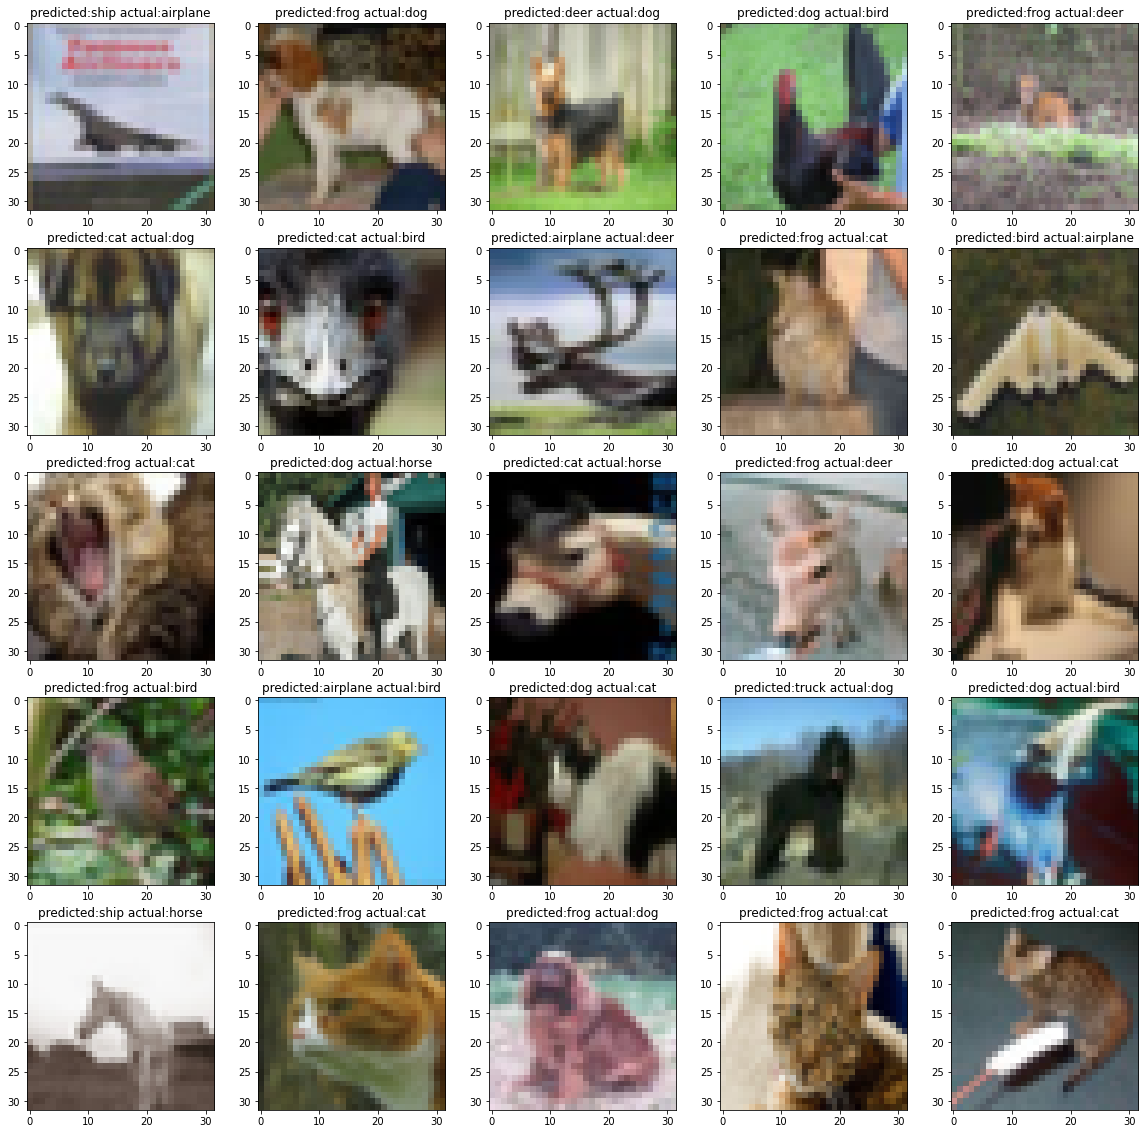

In [0]:
preds = np.argmax(y_pred, axis=1)
tests = np.argmax(testY, axis=1)
mistakes = np.nonzero(preds-tests)[0]
print(f'Test accuracy: {(1 - len(mistakes)/len(tests)):.2f} ({len(mistakes)} of {len(tests)})')
mistakes = mistakes[:25]
examples = []
fig = plt.figure(figsize=(20,20))
for i, ind in enumerate(mistakes, start=1):
    ind = int(ind)
    fig.add_subplot(5,5, i)        
    plt.imshow(testX[ind])
    plt.title(f'predicted:{labels[preds[ind]]} actual:{labels[tests[ind]]}')
    # examples.append(wandb.Image(x, caption=f'predicted:{y_pred} actual:{y}'))
    # print(y_pred,y)
    # plt.figure()
    # plt.title()
#wandb.log(dict(examples=examples))


In [0]:
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))


> 72.580


In [0]:
wandb.save("mymodel.h5")
model.save(os.path.join(wandb.run.dir, "mymodel.h5"))